/tmp/ipykernel_26045/3924513087.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # 支持所有matplotlib色表：plasma, coolwarm等


tensor(0.0336, device='cuda:0') tensor(0.3087, device='cuda:0')


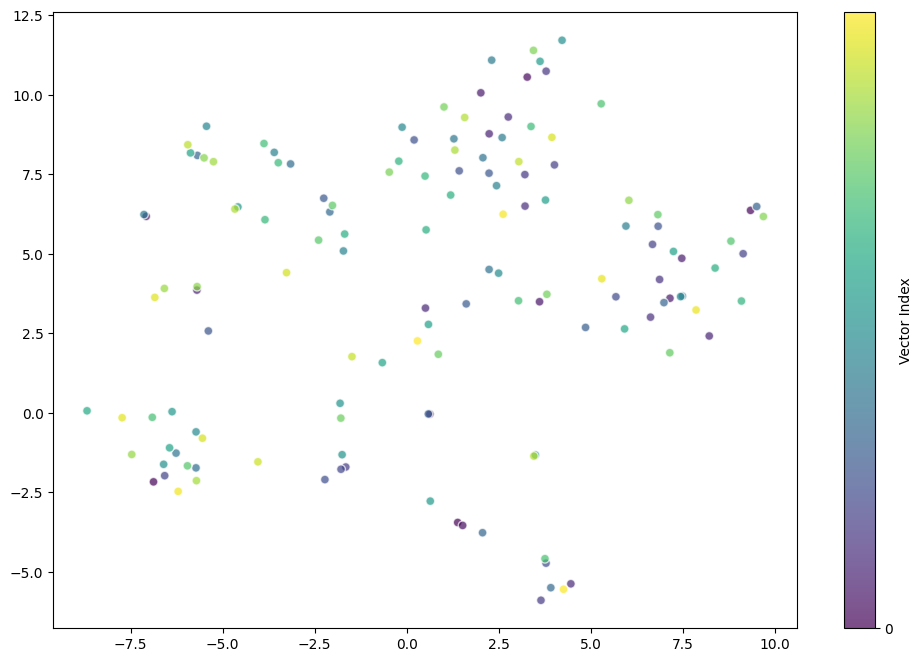

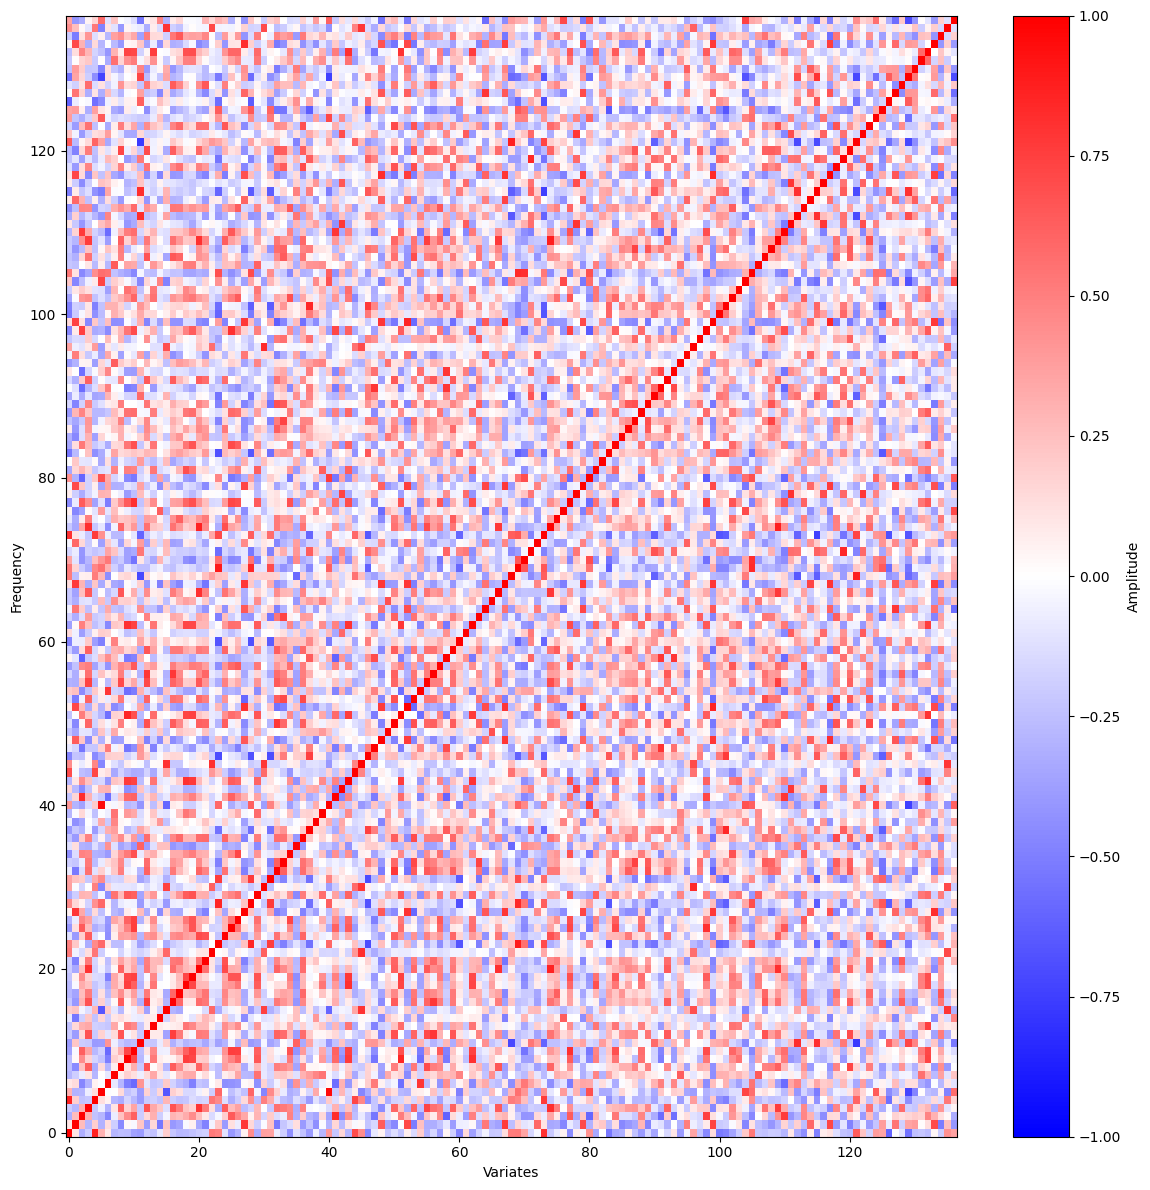

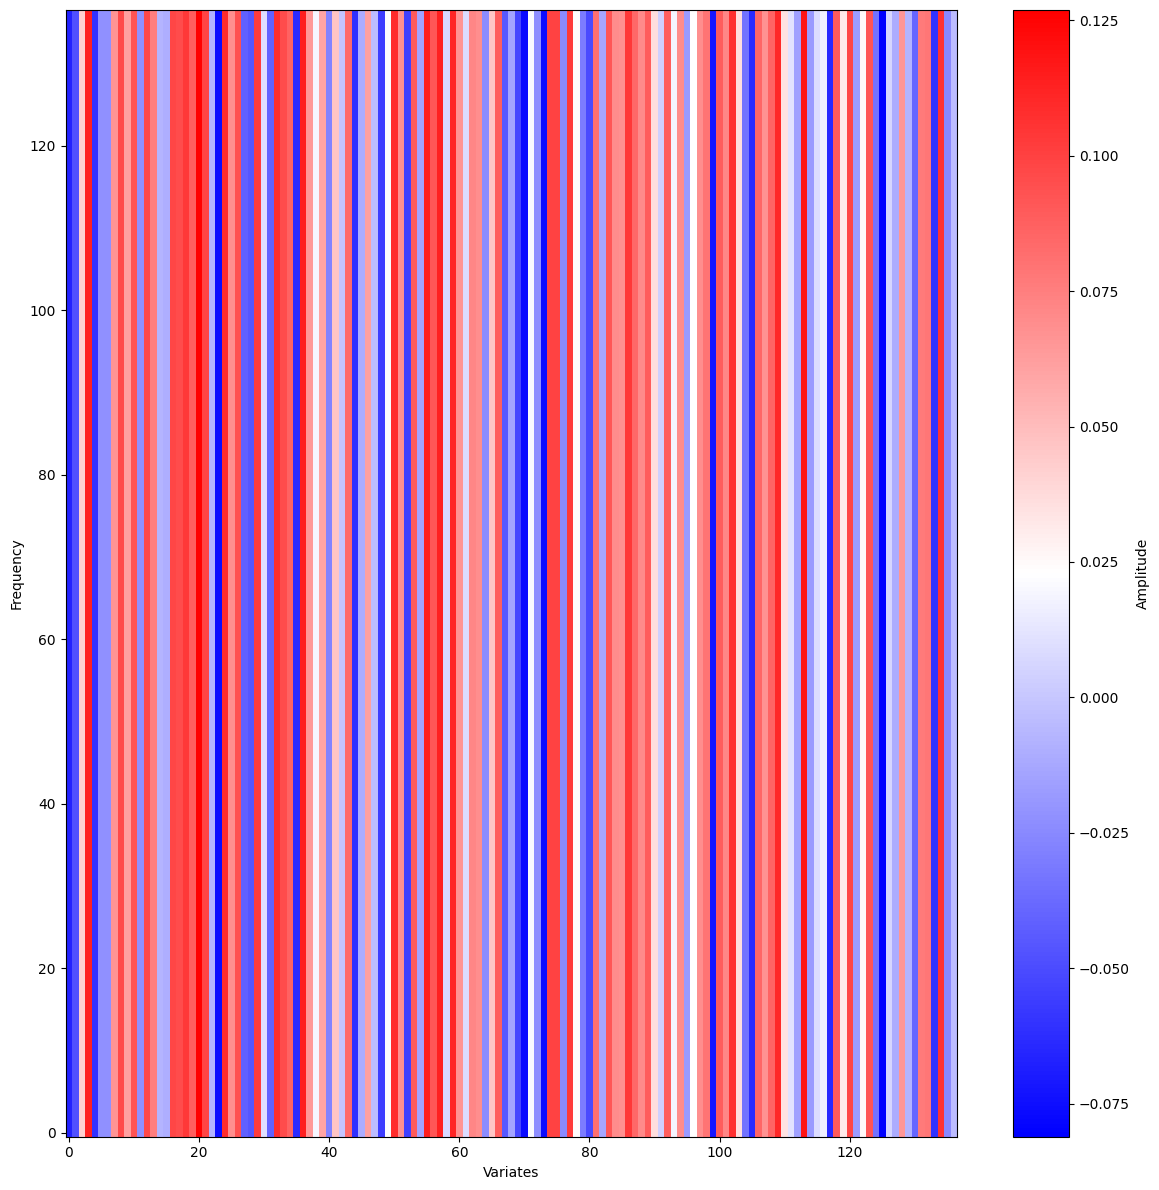

/tmp/ipykernel_26045/3924513087.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # 支持所有matplotlib色表：plasma, coolwarm等


tensor(0.2412, device='cuda:0') tensor(0.2313, device='cuda:0')


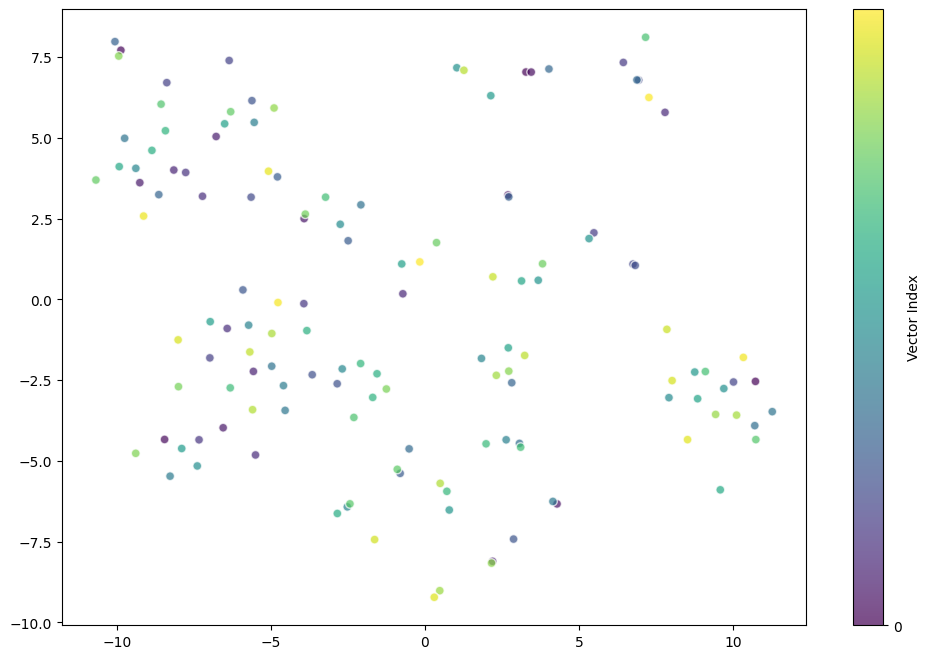

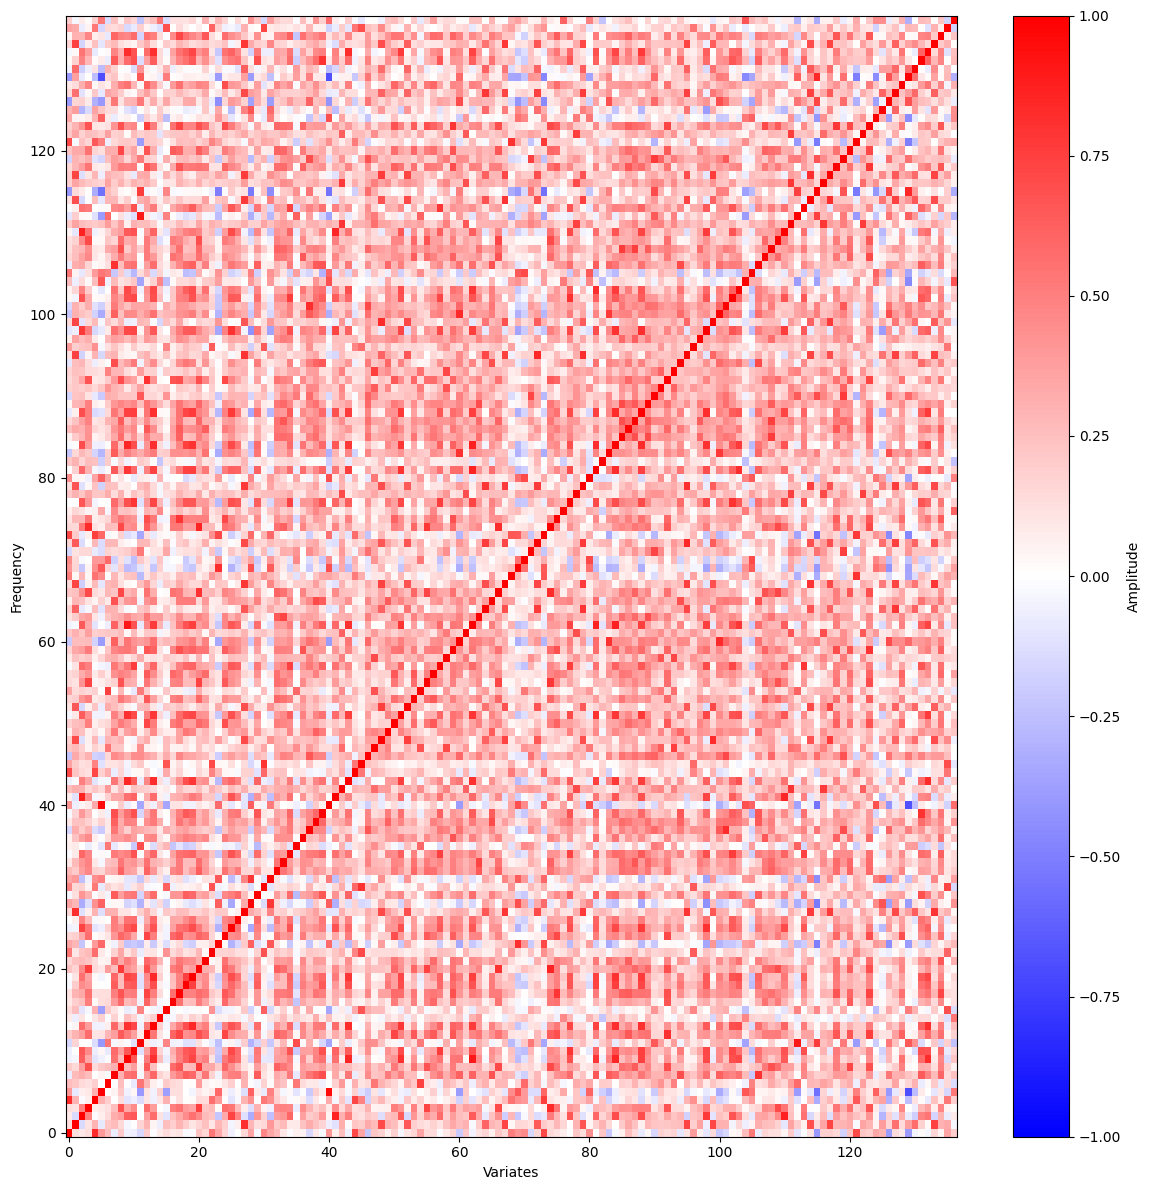

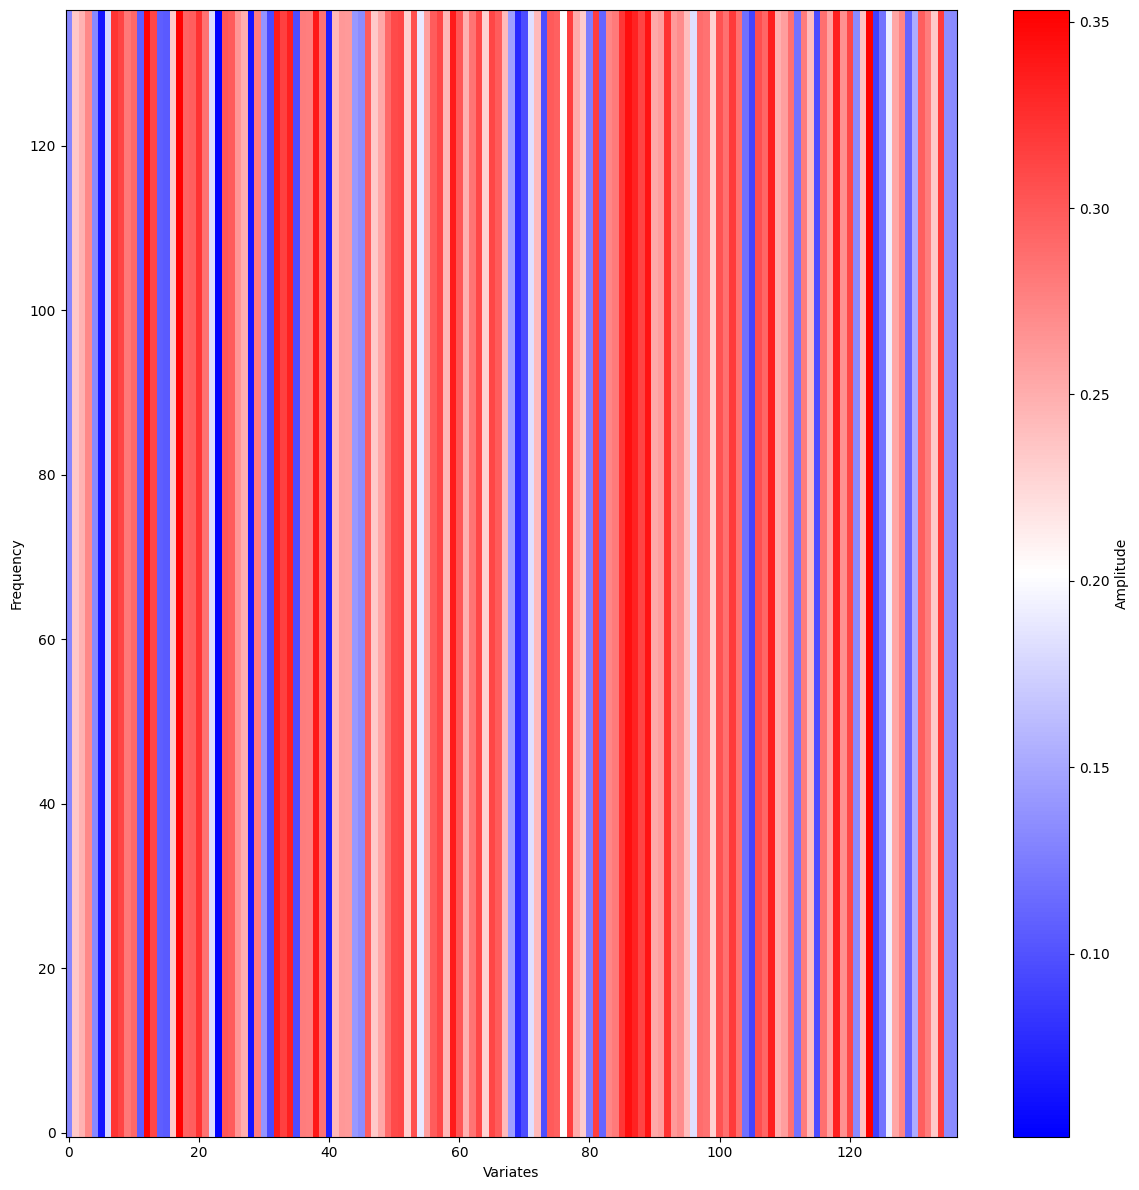

/tmp/ipykernel_26045/3924513087.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # 支持所有matplotlib色表：plasma, coolwarm等


tensor(0.0780, device='cuda:0') tensor(0.2012, device='cuda:0')


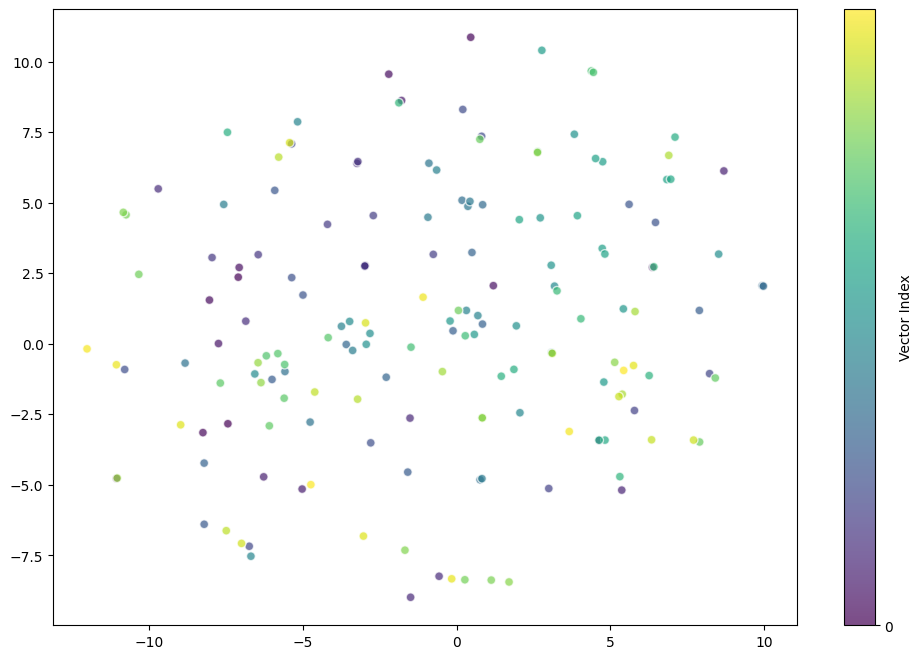

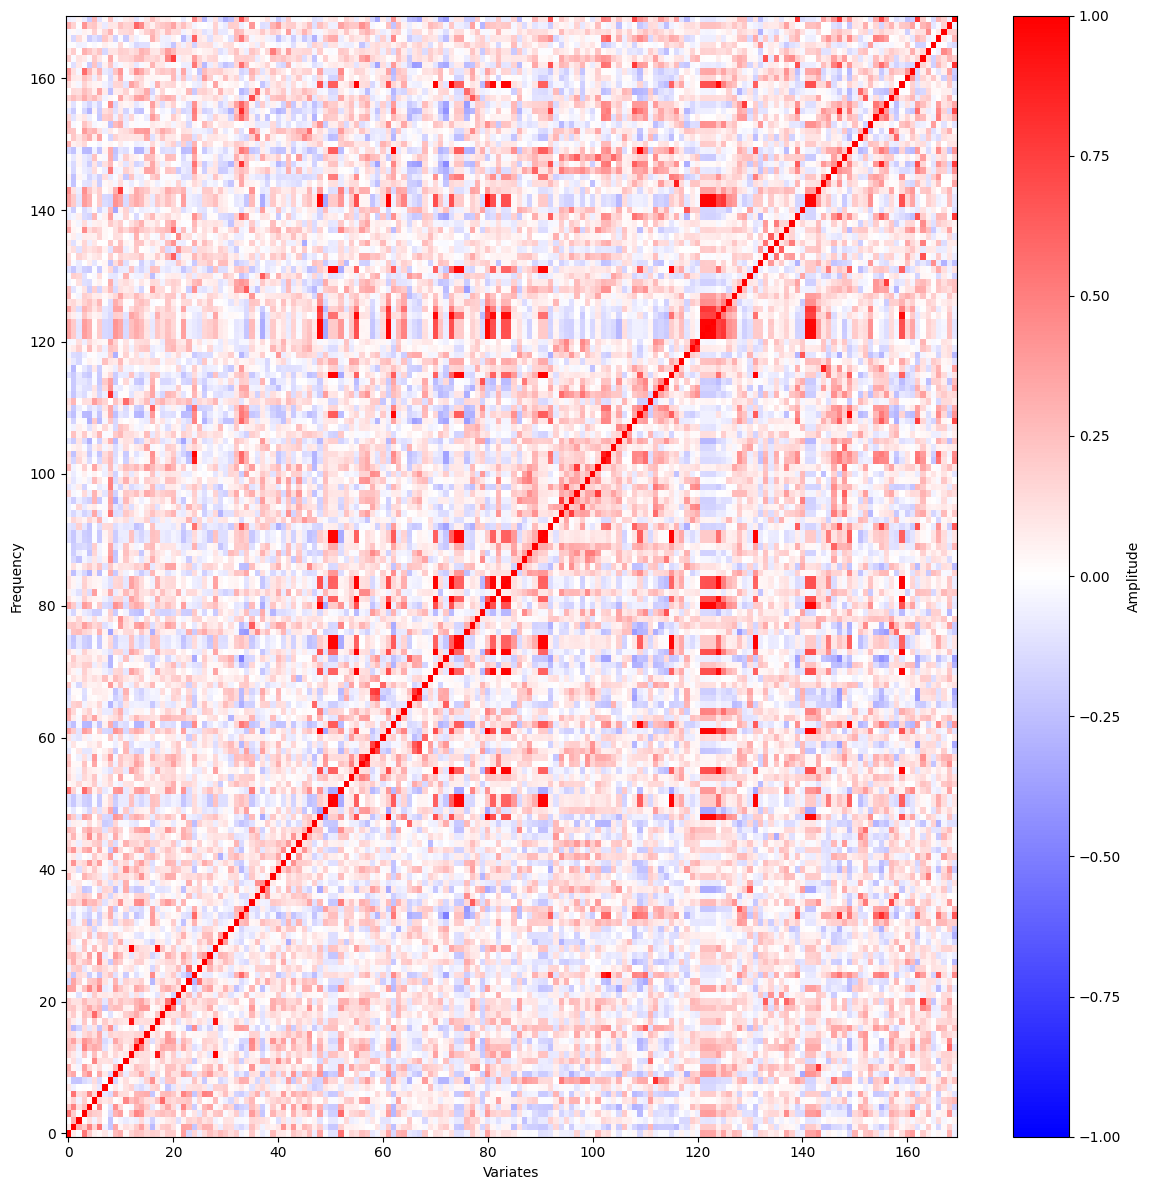

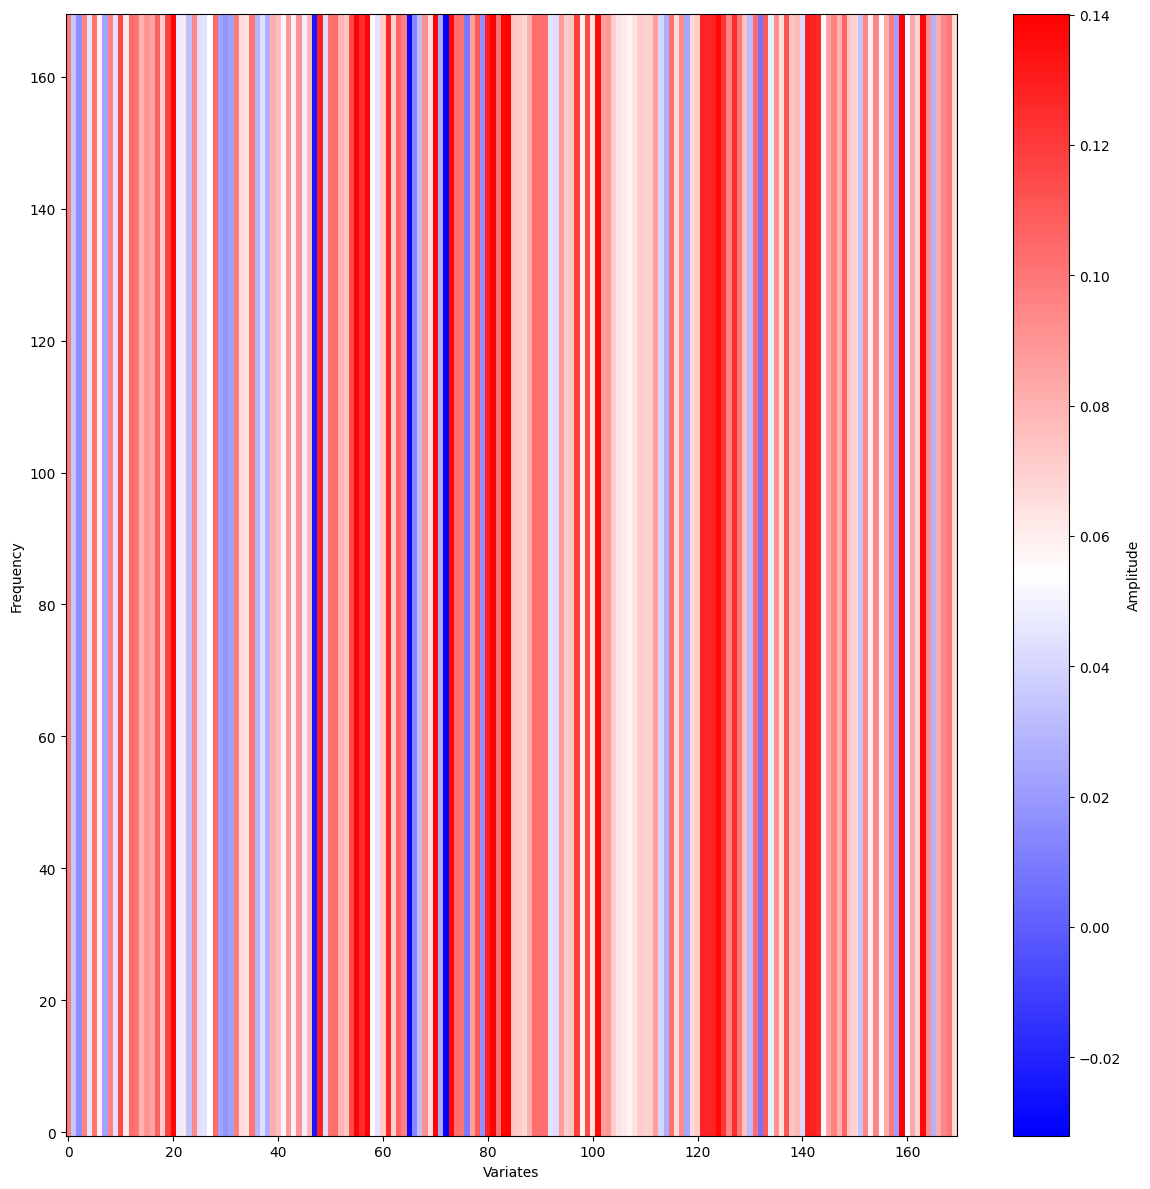

/tmp/ipykernel_26045/3924513087.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # 支持所有matplotlib色表：plasma, coolwarm等


tensor(0.1153, device='cuda:0') tensor(0.1913, device='cuda:0')


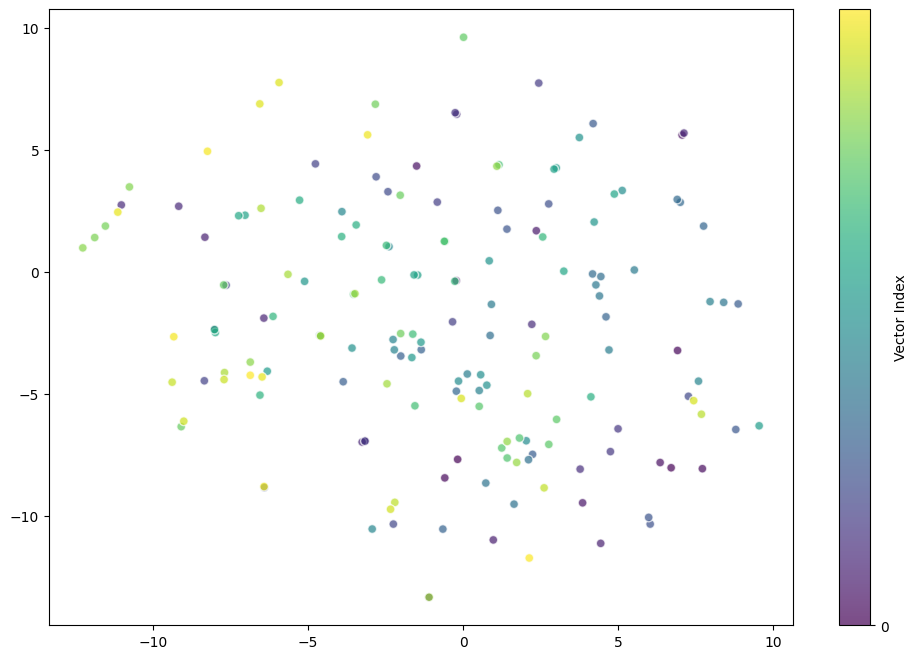

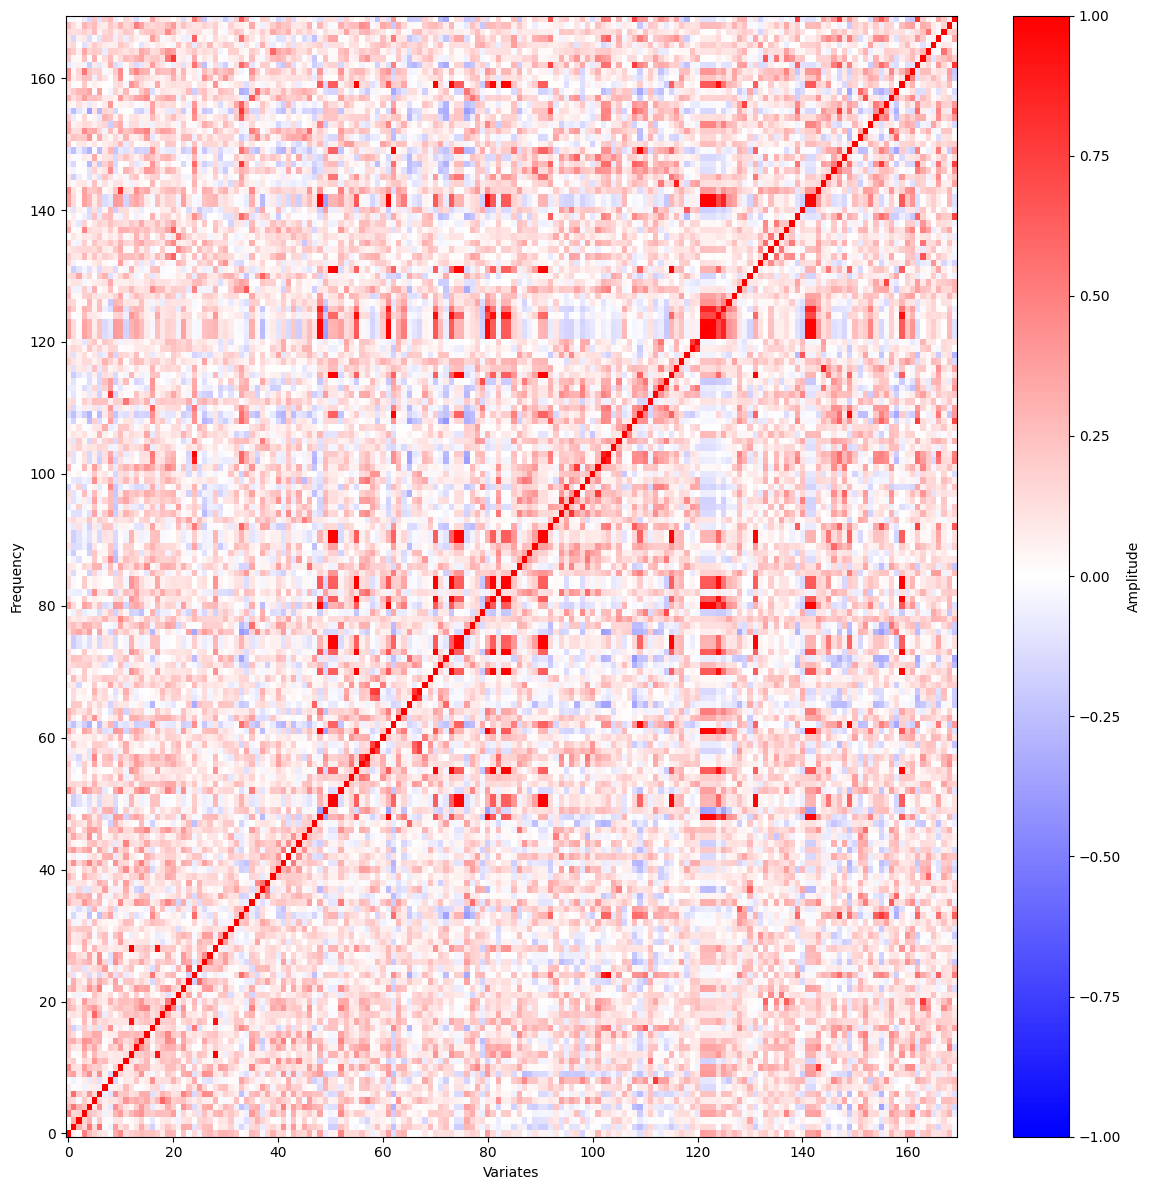

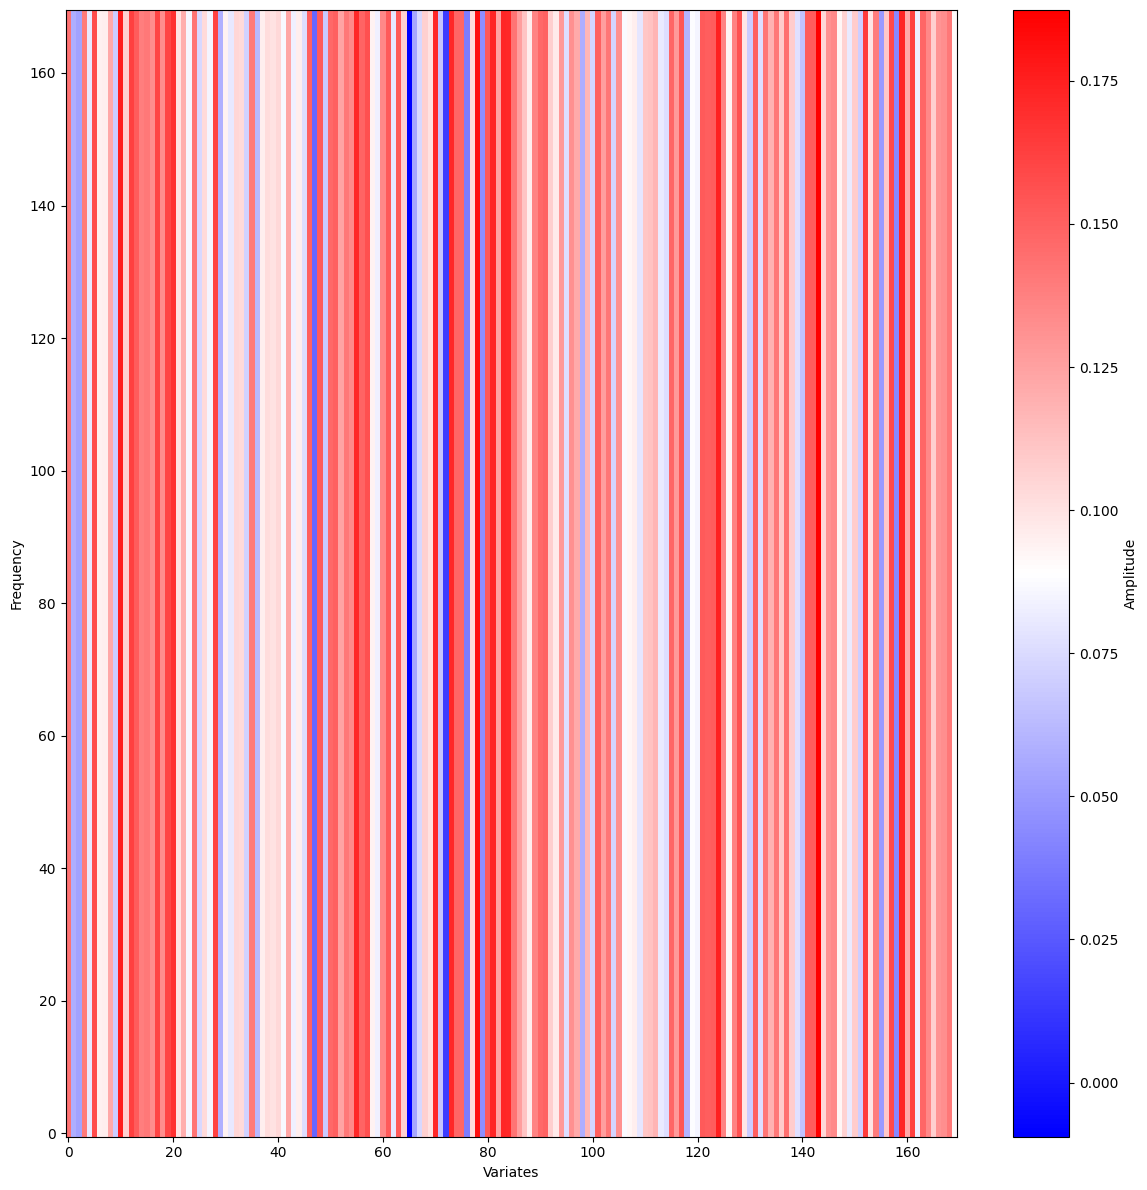

tensor([[ 1.0000,  0.0710,  0.0036,  ...,  0.1475,  0.2601, -0.0386],
        [ 0.0710,  1.0000,  0.3051,  ...,  0.1184,  0.1274, -0.0384],
        [ 0.0036,  0.3051,  1.0000,  ...,  0.1443,  0.0401,  0.0187],
        ...,
        [ 0.1475,  0.1184,  0.1443,  ...,  1.0000,  0.1694,  0.2100],
        [ 0.2601,  0.1274,  0.0401,  ...,  0.1694,  1.0000,  0.0775],
        [-0.0386, -0.0384,  0.0187,  ...,  0.2100,  0.0775,  1.0000]],
       device='cuda:0')

In [13]:
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from basicts.utils.parameter import load_parameter
import torch
import torch.nn.functional as F

from basicts.utils.visualize import plot_mesh
from sklearn.manifold import TSNE


# note 这个文件的目的，是对模型的参数进行可视化，从而实现对模型的分析和方法的justification

def visualize_time_embedding_similarity_matrix(parameter_path: str):
    """
    展示staeformer模型的时间嵌入，用来证明两件事：
    1. 不同时刻的时间步具有不同的相似度分布
    2. 小样本场景下可以得到相似的分布
    :param parameter_path: 训练出来的参数位置
    """
    parameters = load_parameter(parameter_path)
    #print(parameters.keys())
    tod_embeddings = parameters['adaptive_embedding']
    tod_embeddings = torch.permute(tod_embeddings, (1, 0, 2))
    #print(tod_embeddings.shape)
    tod_embeddings = tod_embeddings.reshape(tod_embeddings.shape[0], -1)
    # (tod, tod_dim)
    normalized_tod_embeddings = F.normalize(tod_embeddings, dim=-1)
    # (tod, tod)
    similarity = torch.mm(normalized_tod_embeddings, normalized_tod_embeddings.t())
    print(torch.mean(similarity), torch.std(similarity))
    plot_mesh(title="Similarity among tod embeddings",
              amplitude=similarity.cpu().numpy(),
              vmin=-1, vmax=1
              )
    mean_similarity = torch.mean(similarity, dim=-1, keepdim=True)
    mean_similarity = mean_similarity.expand_as(similarity)
    #print(mean_similarity.shape)
    plot_mesh(title="Mean Similarity among tod embeddings",
            amplitude=mean_similarity.cpu().numpy(),
            )
    return similarity

def visualize_time_embedding_2D(parameter_path: str, parameter_name: str = "tod_embedding.weight"):
    """
    这个函数的目的，是把时间戳压缩到2维
    """
    parameters = load_parameter(parameter_path)
    #print(parameters.keys())
    # (count_tod, dim)
    tod_embeddings = parameters[parameter_name].cpu().numpy()
    #print(tod_embeddings.shape)
    if  "adaptive_embedding" in parameter_name:
        tod_embeddings = np.transpose(tod_embeddings, (1, 0, 2))
        #print(tod_embeddings.shape)
        tod_embeddings = tod_embeddings.reshape(tod_embeddings.shape[0], -1)
    tsne = TSNE(
        n_components=2,        # 降维到2维
        perplexity=30,         # 典型值5-50，控制局部结构敏感度
        learning_rate=200,     # 典型值10-1000，影响收敛速度
        random_state=42,       # 固定随机种子保证可复现
        init='pca'             # 初始化方式优化（推荐）
    )

    # 执行降维 (count_tod, dim) -> (count_tod, 2)
    tsne_results = tsne.fit_transform(tod_embeddings)
    n_samples = tsne_results.shape[0]
    color_indices = np.linspace(0, 1, n_samples)  # 生成0-1的线性渐变值
    cmap = get_cmap('viridis')  # 支持所有matplotlib色表：plasma, coolwarm等

    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = plt.scatter(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        c=color_indices,
        cmap=cmap,
        alpha=0.7,        # 透明度优化重叠显示
        edgecolors='w',   # 白色边框增强区分度
        s=40             # 点大小调整
    )
    cbar = fig.colorbar(
        scatter,
        ax=ax,
        label='Vector Index',
        ticks=np.linspace(0, 288, 10)  # 显示0,25,50,75,99五个刻度
    )
    # cbar.ax.set_yticklabels(['0','25','50','75','99'])  # 自定义刻度标签


base_pems08 = "/data3/hanzhi/BasicTS/checkpoints/STAEformer/PEMS08_100_12_12/base-1/STAEformer_best_val_MAE.pt"
base_pems08_fs = "/data3/hanzhi/BasicTS/checkpoints/STAEformer/PEMS08_100_12_12/base-fs/STAEformer_best_val_MAE.pt"
base_former_pems08 = "/data3/hanzhi/BasicTS/checkpoints/BaseFormer/PEMS08_100_12_12/base-0/BaseFormer_best_val_MAE.pt"
ssl_pems08 = "/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL/PEMS08_100_12_12/base-softclt/STAEformer_SSL_best_val_MAE.pt"
spatial_softclt_pems08 = "/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL/PEMS08_100_12_12/base-spatial-softclt/STAEformer_SSL_best_val_MAE.pt"

g_ssl_pems08 = "/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL_G/PEMS08_100_12_12/base_gr_0.15/STAEformer_SSL_G_best_val_MAE.pt"
base_pems04 = "/data3/hanzhi/BasicTS/checkpoints/STAEformer/PEMS04_100_12_12/base-0/STAEformer_best_val_MAE.pt"
base_pems04_ssl = "/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL/PEMS04_100_12_12/base-softclt/STAEformer_SSL_best_val_MAE.pt"
decompose_tts_pems08 = "/data3/hanzhi/BasicTS/checkpoints/DecomposeFormer_TTS/PEMS08_100_12_12/base-0/DecomposeFormer_TTS_best_val_MAE.pt"
decompose_tts_pems08_fs = "/data3/hanzhi/BasicTS/checkpoints/DecomposeFormer_TTS/PEMS08_100_12_12/base-fs/DecomposeFormer_TTS_best_val_MAE.pt"

decompose_tts_ssl_pems08 = "/data3/hanzhi/BasicTS/checkpoints/DecomposeFormer_TTS_SSL/PEMS08_100_12_12/base_softclt/DecomposeFormer_TTS_SSL_best_val_MAE.pt"
# similarity0 = visualize_time_embedding_similarity_matrix(decompose_tts_pems08)
#similarity1 = visualize_time_embeddings(g_ssl_pems08)
#similarity_diff = (similarity0 - torch.mean(similarity0, dim=-1, keepdim=True) - similarity1 + torch.mean(similarity1, dim=-1, keepdim=True))
#print(torch.mean(similarity_diff), torch.std(similarity_diff))
#plot_mesh(title="Mean Similarity among tod embeddings",
            #amplitude=similarity_diff.cpu().numpy(),
        #)
base_solar = "/data3/hanzhi/BasicTS/checkpoints/STAEformer/Solar_100_12_12/base-0/STAEformer_best_val_MAE.pt"
base_ssl_solar = "/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL/Solar_100_12_12/base-softclt-0/STAEformer_SSL_best_val_MAE.pt"
#visualize_time_embedding_2D(base_pems08, "adaptive_embedding")
visualize_time_embedding_2D(base_solar, "adaptive_embedding")
visualize_time_embedding_similarity_matrix(base_solar)
visualize_time_embedding_2D(base_ssl_solar, "adaptive_embedding")
visualize_time_embedding_similarity_matrix(base_ssl_solar)
visualize_time_embedding_2D(base_pems08, "adaptive_embedding")
visualize_time_embedding_similarity_matrix(base_pems08)
visualize_time_embedding_2D(ssl_pems08, "adaptive_embedding")
visualize_time_embedding_similarity_matrix(ssl_pems08)

# visualize_time_embedding_2D(base_former_pems08, "adaptive_embedding")

#visualize_time_embedding_2D(decompose_tts_ssl_pems08, "trend_embedding.adaptive_embedding")
#visualize_time_embedding_2D(decompose_tts_ssl_pems08, "seasonal_embedding.adaptive_embedding")

